# Experiments
## Bioit set - basic ARTM with regularizers

In [95]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import artm

- Parameter list
    - number of iterations
    - 

In [96]:
#Preparing input
batch_vectorizer = artm.BatchVectorizer(data_path='../Data/bioit_set/bioit_set_2_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path='../Data/bioit_set/cooc.txt',
    vocab_file_path='../Data/bioit_set/vocab.txt',
    symmetric_cooc_values=True)


In [97]:
#Model parameters
#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        name='TopKernelScore Coherence', 
        class_id='@default_class',
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#defining regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

new_regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
]

#creating the model
num_topics = 5
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]
model_artm = artm.ARTM(topic_names=topic_names, 
                       cache_theta=True,
                       scores=scores,
                       regularizers=regularizers,
                        num_topics = num_topics)

#EM hyperparameters
num_collection_passes = 25
#varying regularization coefficients
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -20
# model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [98]:
#Fitting the model
model_artm.initialize(dictionary = dictionary)
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=num_collection_passes)

In [101]:
def print_measures(model:list):          
    print('Sparsity Phi: {0:.3f} '.format(
        model.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f}'.format(
        model.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f}'.format(
        model.score_tracker['PerplexityScore'].last_value))
    plt.plot(range(model.num_phi_updates),
             model.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Perplexity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('ARTM perp.')
    plt.show()
    
    plt.plot(range(model.num_phi_updates),
         model.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Phi Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Phi sparsity')
    plt.show()
    
    plt.plot(range(model.num_phi_updates),
         model.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Theta Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Theta sparsity')
    plt.show()
    
    df = pd.DataFrame.from_dict(model_artm.score_tracker['TopicKernelScore'].contrast).transpose()
    plt.figure(figsize=(6, 6))
    df.boxplot()
    plt.xlabel('Iteration')
    plt.ylabel('Kernel contrast')
    plt.title('Boxplot of Kernel Contrast across topics by Iteration')
    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
    plt.show()
    
    df = pd.DataFrame.from_dict(model_artm.score_tracker['TopicKernelScore'].purity).transpose()
    plt.figure(figsize=(6, 6))
    df.boxplot()
    plt.xlabel('Iteration')
    plt.ylabel('Kernel purity')
    plt.title('Boxplot of Kernel Purity across topics by Iteration')
    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
    plt.show()
    
    df = pd.DataFrame.from_dict(model_artm.score_tracker['TopKernelScore Coherence'].coherence).transpose()
    plt.figure(figsize=(6, 6))
    df.boxplot()
    plt.xlabel('Iteration')
    plt.ylabel('Kernel coherence')
    plt.title('Boxplot of Kernel Coherence across topics by Iteration')
    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
    plt.show()

Sparsity Phi: 0.990 
Sparsity Theta: 0.641
Kernel contrast: 0.833
Kernel purity: 0.889
Perplexity: 269.859


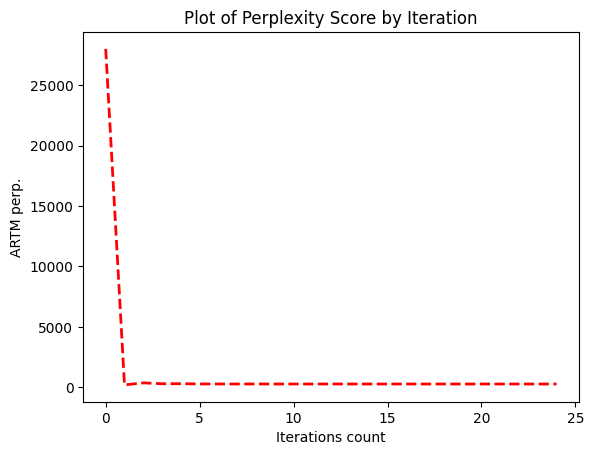

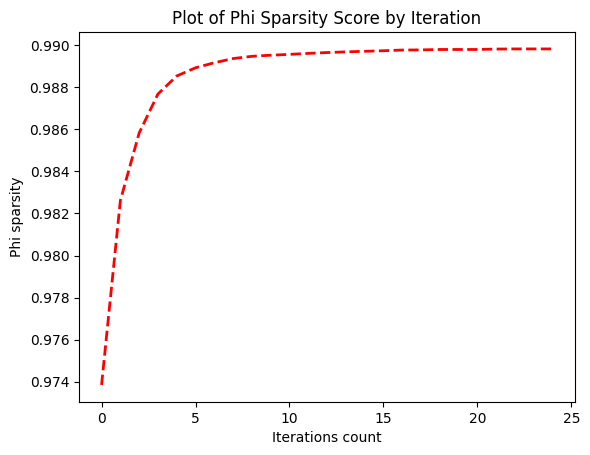

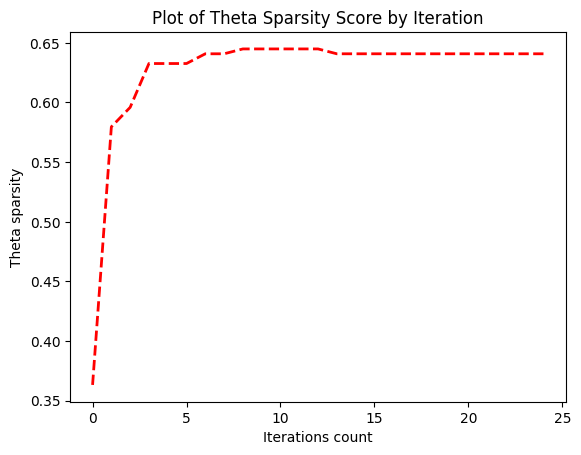

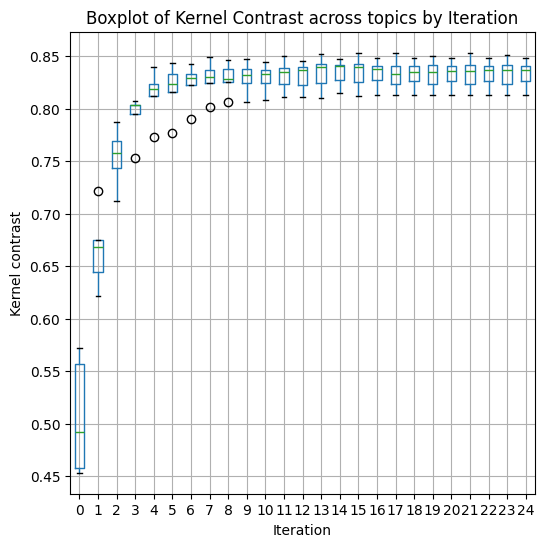

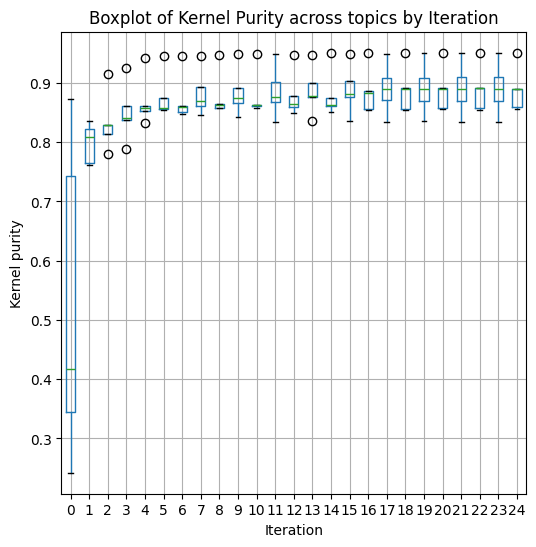

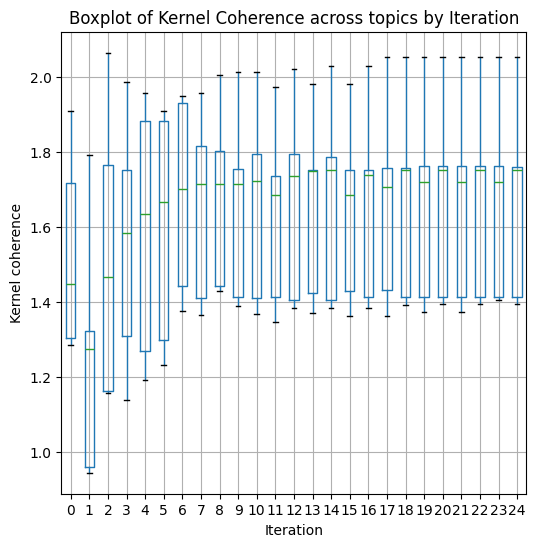

In [102]:
print_measures(model_artm)

In [103]:
for topic_name in model_artm.topic_names:
    print(
        topic_name + ': ', model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0:  ['contig', 'set', 'graph', 'umap', 'number', 'dataset', 'ajb', 'bruijn', 'tree', 'column']
topic_1:  ['kraken', 'normal', 'depth', 'scone', 'wgs', 'call', 'bias', 'fastp', 'filter', 'ion']
topic_2:  ['dna', 'cancer', 'speci', 'ngs', 'detect', 'mash', 'tumor', 'sketch', 'base', 'genet']
topic_3:  ['cell', 'gene', 'method', 'cluster', 'express', 'resist', 'nat', 'protein', 'arg', 'dataset']
topic_4:  ['align', 'variant', 'refer', 'map', 'region', 'algorithm', 'benchmark', 'usa', 'error', 'gatk']


In [104]:
print(model_artm.phi_)
print(model_artm.get_theta())

                       topic_0  topic_1  topic_2  topic_3  topic_4
stenøien                   0.0      0.0      0.0      0.0      0.0
verlag                     0.0      0.0      0.0      0.0      0.0
nies                       0.0      0.0      0.0      0.0      0.0
pulsenetinternational      0.0      0.0      0.0      0.0      0.0
chinen                     0.0      0.0      0.0      0.0      0.0
...                        ...      ...      ...      ...      ...
lims                       0.0      0.0      0.0      0.0      0.0
ideal                      0.0      0.0      0.0      0.0      0.0
venugopal                  0.0      0.0      0.0      0.0      0.0
important                  0.0      0.0      0.0      0.0      0.0
matures                    0.0      0.0      0.0      0.0      0.0

[30123 rows x 5 columns]
               0         1    2    3    4         5    6         7         8   \
topic_0  0.987002  0.273908  0.0  0.0  1.0  0.643710  0.0  0.000000  0.000000   
topic_1 

# Note on iterative training process
- This training process will serve as basis to the subsequent development of the hierarchical model
- Coherence calculation requires co-occurence to be calculated prior to modeling
    - revisit preprocessing step
- Regularizers can be added using ```model.regularizers.add```
- Regularizers can not be removed, but can be "turned-off" by setting regularization coefficient value to 0
- The general training procedure is described by Khodorchenko et al., 2020 as follows:

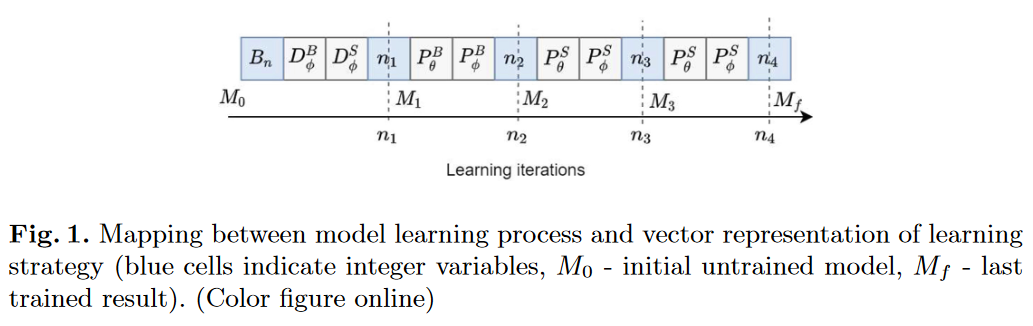

- Suggested hyperparameter search spaces are as follows:

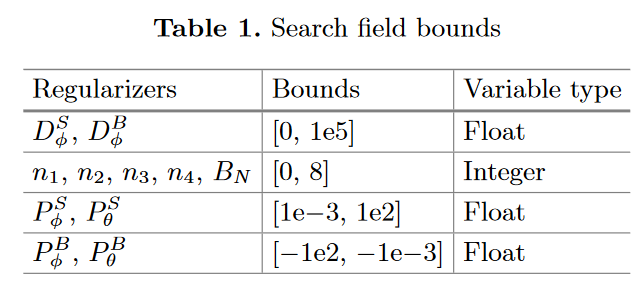

- The differential evolution implementation in Python is possible using the following tool:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html
- Tutorial:
https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/
- Additionally bayesian optimization could be implemented using the following algorithm:
https://github.com/bayesian-optimization/BayesianOptimization